In [21]:
import math
import hashlib
import inspect
import json
import pandas as pd
import numpy as np
import re
from hashlib import sha256
from collections import Counter
import string
import os
import random


import numpy as np
from numpy import dot
from numpy.linalg import norm


# from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import spacy
from spacy.matcher import Matcher
from nltk.tokenize import WordPunctTokenizer
from spacy.lang.en import English
from spacy.matcher import Matcher

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix


In [22]:
df = pd.read_csv("data/covid19_data.csv")
df = pd.read_csv("train_data.csv")

In [23]:
def true_or_false(x, next_phase=False): # clara's
    
    if next_phase:
        if x.lower() in ["correct", "true", "explanatory", "correct attribution", "news", "mostly true","half true", "collections", "half truth", "partially true"]:
            x = "true"
        else:
            x = "false"
    else:

        if x.lower() in ["correct", "true", "explanatory", "correct attribution", "news", "mostly true"]:
            x = "true"
        else:
            x = "false"
    return x

In [24]:
df["class"]=df["class"].apply(str).apply(true_or_false)

## Baseline

In [25]:
# with just title, no preprocessing, vectorizer, chi2 selector, and random_forest clf

# Split in train and validation
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df["class"])

# Build the pipeline
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ("ch2" , SelectKBest(chi2, k=20)),
                     ('classifier', RandomForestClassifier())])

# Train the classifier
text_clf.fit(train_data['title'].values, train_data["class"].values)

predicted = text_clf.predict(test_data['title'].values)

f1_score(y_true=test_data["class"].values, y_pred=predicted, pos_label="true")

0.5

In [26]:
confusion_matrix(test_data["class"].values, predicted)

array([[1086,    2],
       [  12,    7]])

In [27]:
def build_submission(predictions, file_name):
    submission = pd.DataFrame()
    submission['class'] = predictions
    submission.to_csv('./'+file_name+'.csv', index=False)
    return submission

In [28]:
# actual_test_df = pd.read_csv("data/covid19_unlabelled_test.csv")
# actual_pred = text_clf.predict(actual_test_df['title'].values)

# build_submission(actual_pred)

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/rubelrennfix/.virtualenvs/hckt04/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


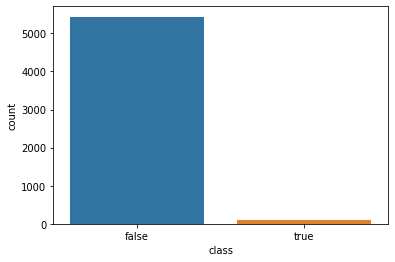

In [107]:
sns.countplot(df['class'])

## Adding title length

In [29]:
df['title_length'] = df['title'].str.split().map(len)

In [30]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]

In [31]:
# Split in train and validation
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Build the pipeline
# first text
title_pipe = Pipeline([
                ('selector', TextSelector("title")),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
                ("ch2" , SelectKBest(chi2, k=20))
                ])

# then numbers
title_lenght_pipe  = Pipeline([
                ('selector', NumberSelector("title_length")),
                ('scaler', StandardScaler())
                ])

# unite them

title_feats = FeatureUnion([('title', title_pipe), 
                            ('title_length', title_lenght_pipe)
                           ])



final_pipeline = Pipeline([
    ('title_feats',title_feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])


In [32]:
final_pipeline.fit(train_data, train_data["class"].values)

predicted = final_pipeline.predict(test_data)

f1_score(y_true=test_data["class"].values, y_pred=predicted, pos_label="true")


0.631578947368421

In [33]:
(test_data["class"]=="true").sum()

13

In [34]:
confusion_matrix(test_data["class"], predicted)

array([[1094,    0],
       [   7,    6]])

In [71]:
actual_test_df = pd.read_csv("data/covid19_unlabelled_test.csv")
actual_test_df = pd.read_csv("test_data.csv")

actual_test_df['title_length'] = actual_test_df['title'].str.split().map(len)
actual_pred = final_pipeline.predict(actual_test_df)

build_submission(actual_pred, "submission2")

,class
0,false
1,true
2,false
3,false
4,false
...,...
2087,false
2088,false
2089,false
2090,false


In [98]:
actual_test_df[actual_pred=='true']#['title']

,verifiedby,country,title,published_date,country1,country2,country3,country4,article_source,ref_source,source_title,content_text,category,lang,source_title_en,title_length
1,snopes,NaN,Did Trump Blame Obama for ‘Bad’ COVID-19 Tests...,2020-05-01 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/trump-blame-...,snopes,Did Trump Blame Obama for 'Bad' COVID-19 Tests?,['U.S. President Donald Trump implied the Obam...,Trump and the Pandemic II,en,Did Trump Blame Obama for 'Bad' COVID-19 Tests?,34
411,snopes,NaN,Did Piers Morgan End His Friendship with Trump...,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/piers-morgan...,snopes,Did Piers Morgan End His Friendship with Trump...,['British media personality Piers Morgan penne...,Entertainment & Media,en,Did Piers Morgan End His Friendship with Trump...,27
441,snopes,NaN,Did a Noted Pathologist Write This Viral Coron...,2020-03-02 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/zinc-lozenge...,snopes,Did a Noted Pathologist Write This Viral Coron...,['A letter providing tips on how to protect ag...,Memes and Misinformation,en,Did a Noted Pathologist Write This Viral Coron...,30
446,snopes,NaN,Did Fauci Warn Trump in 2017 That a ‘Surprise ...,2020-05-14 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/fauci-warn-s...,snopes,Did Fauci Warn Trump in 2017 That a 'Surprise ...,['NAIAD director Dr. Anthony Fauci warned in J...,Prophecies and Predictions,en,Did Fauci Warn Trump in 2017 That a 'Surprise ...,33
604,snopes,NaN,Did an Infectious Disease Specialist Write ‘I ...,2020-03-09 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/abdu-sharkaw...,snopes,Did an Infectious Disease Specialist Write 'I ...,"['Dr. Abdu Sharkawy, an infectious diseases sp...",Memes and Misinformation,en,Did an Infectious Disease Specialist Write 'I ...,30
1116,snopes,NaN,Did Trump Say More COVID-19 Testing Makes the ...,2020-05-14 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/trump-more-t...,snopes,Did Trump Say More COVID-19 Testing Makes the ...,['U.S. President Donald Trump said that increa...,Trump and the Pandemic II,en,Did Trump Say More COVID-19 Testing Makes the ...,26
1270,snopes,NaN,Did Bill Mitchell Tweet ‘Let Me Know’ When COV...,2020-05-01 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/bill-mitchel...,snopes,Did Bill Mitchell Tweet 'Let Me Know' When COV...,['Right-wing commentator Bill Mitchell tweeted...,Memes and Misinformation II,en,Did Bill Mitchell Tweet 'Let Me Know' When COV...,27
1298,Newschecker,India,Experts in China found that the coronavirus c...,2020/05/11,India,NaN,NaN,NaN,https://www.newschecker.in/article/news-detail...,poynter,NaN,NaN,NaN,tl,NaN,12
1396,snopes,NaN,Did Trump Praise China for Its ‘Transparency’ ...,2020-04-16 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/trump-china-...,snopes,Did Trump Praise China for Its 'Transparency' ...,['U.S. President Donald Trump praised China fo...,Trump and the Pandemic II,en,Did Trump Praise China for Its 'Transparency' ...,24
1483,snopes,NaN,Did Trump Suggest Injecting Disinfectants as C...,2020-04-24 00:00:00,NaN,NaN,NaN,NaN,https://www.snopes.com/fact-check/trump-disinf...,snopes,Did Trump Suggest Injecting Disinfectants as C...,['U.S. President Donald Trump suggested during...,Prevention and Treatments II,en,Did Trump Suggest Injecting Disinfectants as C...,33


## 3rd submission add country rate


In [46]:
train_data['source_title_en'] = train_data['source_title_en'].replace(np.nan, '')

/home/rubelrennfix/.virtualenvs/hckt04/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
source_pipe = Pipeline([('selector', TextSelector("source_title_en")),
                        ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
                        ("ch2" , SelectKBest(chi2, k=20))
                        ])

feats = FeatureUnion([('title', title_pipe), 
                            ('title_length', title_lenght_pipe),
                            ('source_title', source_pipe),
                           ])

new_pipeline = Pipeline([
    ('feats',feats),
    ('classifier', RandomForestClassifier(max_depth=None, random_state=42)),
    ])

In [69]:
new_pipeline.fit(train_data, train_data["class"].values)

predicted = final_pipeline.predict(test_data)

f1_score(y_true=test_data["class"].values, y_pred=predicted, pos_label="true")


ValueError: max_depth must be greater than zero. 